Libraries & Parameters

In [1]:
!pip install -q awswrangler

import awswrangler as wr
import pandas as pd

import boto3
import pytz

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import datetime
from sagemaker import get_execution_role

import warnings, scipy 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec

from scipy.optimize import curve_fit
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict


plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
warnings.filterwarnings("ignore")
%matplotlib inline

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
ERROR: redshift-connector 2.0.878 has requirement pytz<2021.9,>=2020.1, but you'll have pytz 2019.3 which is incompatible.


In [2]:
# Get Sagemaker Role
role = get_execution_role()
print(role)

Couldn't call 'get_role' to get Role ARN from role name AmazonSageMaker-ExecutionRole-20210503T205912 to get Role path.
Assuming role was created in SageMaker AWS console, as the name contains `AmazonSageMaker-ExecutionRole`. Defaulting to Role ARN with service-role in path. If this Role ARN is incorrect, please add IAM read permissions to your role or supply the Role Arn directly.


arn:aws:iam::506926764659:role/service-role/AmazonSageMaker-ExecutionRole-20210503T205912


___
# 1.) Download Data

## S3 parameters

In [3]:
# Flight data from Sagemaker Data Wrangler
bucket = 'sagemaker-us-west-2-506926764659/export-flow-05-16-30-08-0c003aed/output/data-wrangler-flow-processing-05-16-30-08-0c003aed/b98f4f8c-ddaf-4ee1-99da-b0dd09f47a21/default'
filename = 'part-00000-92fade68-00c4-41b3-9182-593084da2eae-c000.csv'
path_to_file = 's3://{}/{}'.format(bucket, filename)

# # Flight data from entire year of 2011
# bucket = 'from-public-data/carrier-perf/transformed'
# filename = 'airOT2011all.csv'
# path_to_file = 's3://{}/{}'.format(bucket, filename)

# # Flight data from 2011_01 
# bucket = 'from-public-data/carrier-perf/transformed/airOT2011'
# filename = 'airOT201101.csv'
# path_to_file = 's3://{}/{}'.format(bucket, filename)


# ________________________________________________________________
# Supporting dataset useful for EDA and understanding data
#   - airport codes
#   - airline codes
bucket2 = 'from-public-data/carrier-perf/raw'
file_airport = 'airports.csv'
file_airline = 'airlines.csv'

path_to_file_airport = 's3://{}/{}'.format(bucket2, file_airport)
path_to_file_airline = 's3://{}/{}'.format(bucket2, file_airline)

=== === === === ===
## Download data from S3

### 1. Flights Performance dataset

In [4]:
df = wr.s3.read_csv([path_to_file])
# df

A whopping 7,294,649 rows (records) of JUST year 2007!  Thanks to all the Sagemaker Data Wrangler, I was able to already do some data cleaning and adjustment:
  - Create new variable `late_flight` depending on `DEP_DELAY`
  - Trim value to remove outliers for `DEP_DLAY`
  - Drop records for Cancelled flights `CANCELED` == 1 (doesn't make much sense to have flights that's irrelevant to flights delay when flight never occur)

### 2. Airports & Airlines dataset

In [5]:
df_airports = wr.s3.read_csv([path_to_file_airport])
df_airlines = wr.s3.read_csv([path_to_file_airline])
# df_airlines

=== === === === ===
## Initial Data Clean-up and Organization

In [6]:
# rename 'DAY_OF_MONTH' column to 'DAY' (in prep of transforming to datetime format)
df = df.rename(columns={'DAY_OF_MONTH': 'DAY'})
# df

### 1. Date / Time modifications

Make date and time more appropriate.  This will make it easier when making plots.

In [7]:
# Create a datetime field `DATE`
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH','DAY']])

In [8]:
# Convert 'HHMM' string to datetime.time
def format_heure(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == 2400: chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return heure

In [9]:
df['DEP_TIME'] = df['DEP_TIME'].apply(format_heure)
df['ARR_TIME'] = df['ARR_TIME'].apply(format_heure)

### 2. Organize Columns

Let's organize columns (features) to be more logical

In [10]:
variables_to_remove = ['ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID']
df.drop(variables_to_remove, axis = 1, inplace = True)

df = df[[
    'DATE',
    'YEAR',
    'MONTH',
    'DAY',
    'DAY_OF_WEEK',
    'UNIQUE_CARRIER',
    'ORIGIN',
    'DEST',
    'DEP_TIME',
    'DEP_DELAY',
    'DEP_DELAY_no_outlier',
    'ACTUAL_ELAPSED_TIME',
    'AIR_TIME',
    'DISTANCE',
    'ARR_TIME',
    'ARR_DELAY',
    'CARRIER_DELAY',
    'WEATHER_DELAY',
    'NAS_DELAY',
    'SECURITY_DELAY',
    'LATE_AIRCRAFT_DELAY',
    'late_flight']]

In [11]:
df_AA = df.loc[df['UNIQUE_CARRIER'] == 'AA']

distinct_airlines = df_AA.UNIQUE_CARRIER.unique()
print('New dataset has {0} records with {1} variables, containing only airlines {2}'.format(df_AA.shape[0], df_AA.shape[1], distinct_airlines))

New dataset has 615933 records with 22 variables, containing only airlines ['AA']


In [12]:
df_AA

,DATE,YEAR,MONTH,DAY,DAY_OF_WEEK,UNIQUE_CARRIER,ORIGIN,DEST,DEP_TIME,DEP_DELAY,DEP_DELAY_no_outlier,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,ARR_TIME,ARR_DELAY,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,late_flight
20534,2007-01-01,2007,1,1,1,AA,JFK,LAX,08:54:00,-6.0,-6,396.0,333.0,2475.0,12:30:00,20.0,0.0,0.0,20.0,0.0,0.0,late
20535,2007-01-02,2007,1,2,2,AA,JFK,LAX,08:55:00,-5.0,-5,400.0,326.0,2475.0,12:35:00,25.0,0.0,0.0,25.0,0.0,0.0,late
20536,2007-01-03,2007,1,3,3,AA,JFK,LAX,08:56:00,-4.0,-4,377.0,312.0,2475.0,12:13:00,3.0,NaN,NaN,NaN,NaN,NaN,late
20537,2007-01-04,2007,1,4,4,AA,JFK,LAX,09:01:00,1.0,1,408.0,352.0,2475.0,12:49:00,39.0,0.0,0.0,39.0,0.0,0.0,late
20538,2007-01-05,2007,1,5,5,AA,JFK,LAX,08:55:00,-5.0,-5,425.0,360.0,2475.0,13:00:00,50.0,0.0,0.0,50.0,0.0,0.0,late
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6770764,2007-12-29,2007,12,29,6,AA,ORD,MCI,10:02:00,22.0,22,88.0,69.0,403.0,11:30:00,25.0,0.0,21.0,3.0,0.0,1.0,late
6770765,2007-12-30,2007,12,30,7,AA,ORD,MCI,09:33:00,-7.0,-7,85.0,66.0,403.0,10:58:00,-7.0,NaN,NaN,NaN,NaN,NaN,late
6770766,2007-12-31,2007,12,31,1,AA,ORD,MCI,09:36:00,-4.0,-4,107.0,79.0,403.0,11:23:00,18.0,0.0,0.0,18.0,0.0,0.0,late
6770767,2007-12-13,2007,12,13,4,AA,BOS,MIA,09:15:00,0.0,0,221.0,176.0,1258.0,12:56:00,11.0,NaN,NaN,NaN,NaN,NaN,late


___
# 2.) Explorational Data Analysis

## Corrleations

Text(0.5, 1, 'Correlation Heatmap')

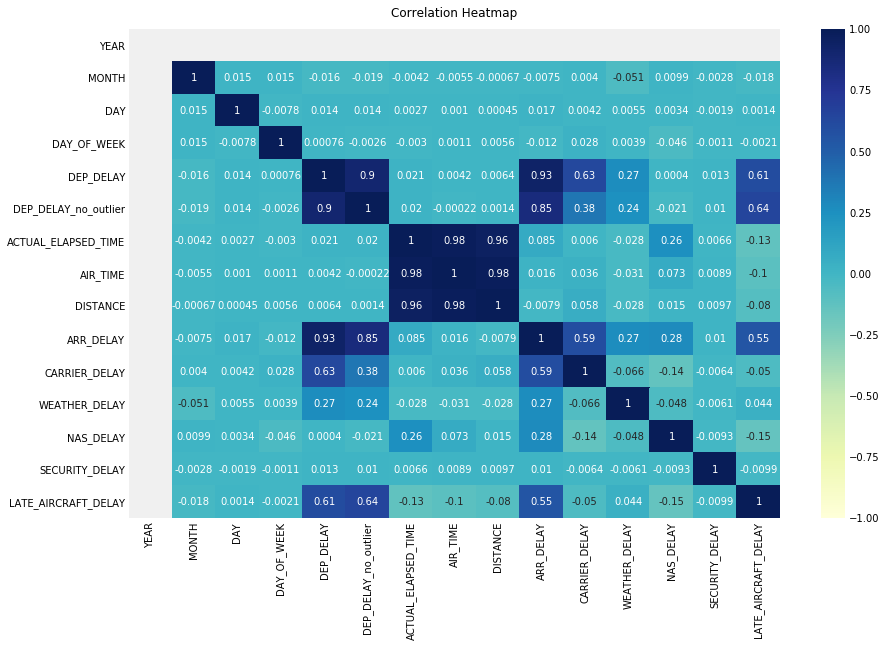

In [13]:
# increase figure size
plt.figure(figsize=(13, 9))
heatmap = sns.heatmap(df_AA.corr(), vmin=-1, vmax=1, annot=True, cmap="YlGnBu")

# define title
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

# ref. https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e

Sure enough, there's only year 2007 data